# Project 5 - interactive notebook

Adapted from https://github.com/AlexiaNomena/SC2_VASIL notebooks

## Import libraries

In [47]:
"""Compute Cross Reactivity between two groups of lineage lists"""
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'scripts'))
from Compute_FR_SC2 import Compute_FR_SC2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Fold resistance plots

In [106]:
### Two list of lineages to investigate and their corresponding files mutation profile as dictionary ###
### Here we use the same list of lineages to obtain a symetrical cross-reactivity output
lineage_list_1 = ["JN.1", "JN.2", "JN.3", "KP.3", "XBB.1.5"]

mut_dic_1 = { "JN.1": "../../data/mut_profiles/JN_1.txt",
              "JN.2": "../../data/mut_profiles/JN_2.txt",
              "JN.3":"../../data/mut_profiles/JN_3.txt",
              "KP.3":"../../data/mut_profiles/KP_3.txt",
              "XBB.1.5":"../../data/mut_profiles/XBB_1_5.txt"
             }

lineage_list_2 = ["JN.1", "JN.2", "JN.3", "KP.3", "XBB.1.5"]

mut_dic_2 = { "JN.1": "../../data/mut_profiles/JN_1.txt",
              "JN.2": "../../data/mut_profiles/JN_2.txt",
              "JN.3":"../../data/mut_profiles/JN_3.txt",
              "KP.3":"../../data/mut_profiles/KP_3.txt",
              "XBB.1.5":"../../data/mut_profiles/XBB_1_5.txt"
             }

### Compute Cross ###
Cross_dic, epitopes = Compute_FR_SC2(lins_1 = lineage_list_1, 
                                lins_2 = lineage_list_2, 
                                Muts_1 = mut_dic_1,
                                Muts_2 = mut_dic_2,
                                dms_data = "../../data/dms_per_ab_per_site.csv", 
                                add_WT = False) # add wild-type

### Save results to csv ###
FR_epitopes = []
FR_epitopes_dict = {}
for ab in epitopes:
    Cross_df = pd.DataFrame(Cross_dic[ab], 
                            index = Cross_dic["variant_list1"], 
                            columns = Cross_dic["variant_list2"]) ### dataframes are already aligned
    FR_epitopes.append(Cross_df)
    FR_epitopes_dict[ab] = Cross_df
    Cross_df.to_csv("../../out/cross_sim_%s.csv"%ab)
    print("----------------------------------")
    print("Cross reactivity to epitope %s"%ab)
    print(Cross_df)

----------------------------------
Cross reactivity to epitope A
              JN.1       JN.2       JN.3       KP.3    XBB.1.5
JN.1      1.000000   8.672726   8.672726  11.241357  19.595890
JN.2      8.672726   1.000000   1.000000  19.746683  13.968328
JN.3      8.672726   1.000000   1.000000  19.746683  13.968328
KP.3     11.241357  19.746683  19.746683   1.000000  33.471536
XBB.1.5  19.595890  13.968328  13.968328  33.471536   1.000000
----------------------------------
Cross reactivity to epitope B
                JN.1         JN.2         JN.3         KP.3      XBB.1.5
JN.1        1.000000    17.701006    17.701006    21.600505  2765.140256
JN.2       17.701006     1.000000     1.000000    33.886794  3059.545183
JN.3       17.701006     1.000000     1.000000    33.886794  3059.545183
KP.3       21.600505    33.886794    33.886794     1.000000  2843.034056
XBB.1.5  2765.140256  3059.545183  3059.545183  2843.034056     1.000000
----------------------------------
Cross reactivity to

In [10]:
"""Compute Variant Fitness for a tested variant which 
must always be included in lineage_list_1 because of asymetry of the cross reactivity table
"""
from Fitness_SC2 import Immune_dynamics
import numpy as np
### load pharmacokinetics used : each columns represents a combination of pharamacokinetics parameters ####
PK_dframe = pd.read_csv("../../data/PK_for_all_Epitopes.csv")

### Drop irrelevant columns
PK_dframe.drop(columns = ["Day since activation", "Unnamed: 0"], inplace = True)

### Potency of Epitope classes ####
potency = {'A': 0.2581345199991067, 'B': 0.15002419850071694, 'C': 0.5961299385766167, 
           'D1': 0.6163901409163847, 'D2': 0.17142504894868016, 'E12': 1.0086135510680292, 
           'E3': 2.4564828793602276, 'F1': 3.0147209112838187, 'F2': 0.8418299673818657, 
           'F3': 0.8862488439645552, 'NTD': 1.0}

IC50xx = 1.5245833433873104
IC50xx_dic = {epitopes[i]:IC50xx*potency[epitopes[i]] for i in range(len(epitopes))}


In [11]:
IC50xx_dic

{'A': 0.3935475895439166,
 'B': 0.22872439413922455,
 'C': 0.9088497748484102,
 'D1': 0.9397381418692771,
 'D2': 0.2613517742665121,
 'E12': 1.5377154198730436,
 'E3': 3.7451128811887027,
 'F1': 4.5961932863047235,
 'F2': 1.2834399462346753,
 'F3': 1.3511602256046202,
 'NTD': 1.5245833433873104}

In [12]:
def upper_tri_heatmap(ax, M, labels, title, cmap='Reds', vmin=None, vmax=None, fmt="{:.2f}"):
    import matplotlib as mpl
    import numpy as np
    import matplotlib.pyplot as plt

    M = np.asarray(M, float)
    n = M.shape[0]

    # mask lower+diag
    i, j = np.indices((n, n))
    Upper = M.copy()
    Upper[i >= j] = np.nan

    cmap_obj = mpl.cm.get_cmap(cmap).copy()
    cmap_obj.set_bad('white')

    im = ax.imshow(np.ma.masked_invalid(Upper), cmap=cmap_obj, vmin=vmin, vmax=vmax, #np.nanpercentile(M, 95)+np.nanpercentile(M, 50),
                   origin='upper', interpolation='none')

    # ticks/labels
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(labels, rotation=55, ha='right'); ax.set_yticklabels(labels)
    # ax.set_xlim(-0.5, n-0.5); ax.set_ylim(n-0.5, -0.5); ax.set_aspect('equal')
    ax.set_xlim(-0.5, n - 0.5); ax.set_ylim(n - 0.5 + 0.03, -0.5 - 0.03)

    # --- NO ax.grid() here ---
    # draw borders ONLY for i < j
    for r in range(n):
        # ax.text(r, r, "0", ha='center', va='center', fontsize=9)
        for c in range(r, n):
            ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, fill=False,
                                       edgecolor='black', lw=0.5))
            ax.text(c, r, fmt.format(M[r, c]), ha='center', va='center', fontsize=9)

    ax.set_title(title, pad=8, fontsize=11)
    return im

In [13]:
from  matplotlib.colors import LinearSegmentedColormap
cmap_red = LinearSegmentedColormap.from_list('rg',["w", "crimson"], N=256) # Choose beautiful red instead of default "red", example: "crimson"
cmap_blue = LinearSegmentedColormap.from_list('bg',["w", "royalblue"], N=256) # Choose beautiful blue instead of default, example: "deepskyblue"
cmap_orange = LinearSegmentedColormap.from_list('og',["w", "coral"], N=256) # Choose beautiful orange instead of default, example: "darkorange"

/tmp/ipykernel_267236/441709734.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap).copy()
/tmp/ipykernel_267236/441709734.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap).copy()
/tmp/ipykernel_267236/441709734.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap).copy()


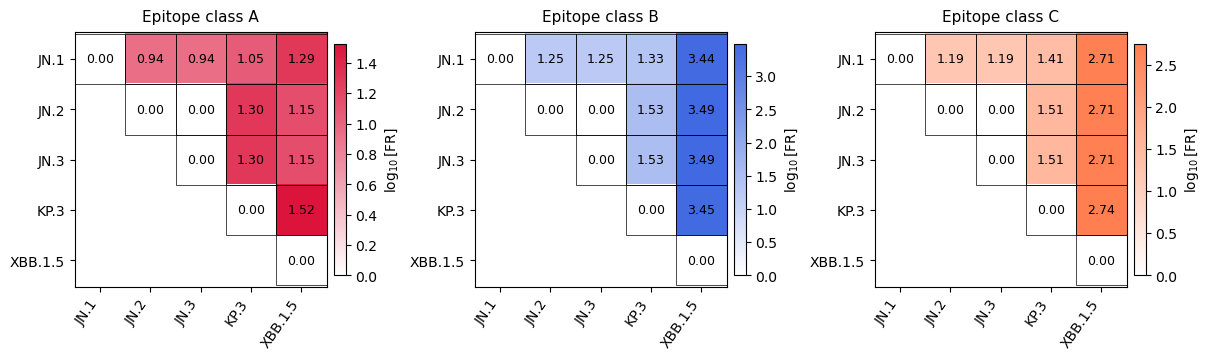

In [16]:
labels = lineage_list_1
n = len(labels)

A = np.log10(FR_epitopes[0].to_numpy())
B = np.log10(FR_epitopes[1].to_numpy())
C = np.log10(FR_epitopes[2].to_numpy())

fig, axes = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True)

imA = upper_tri_heatmap(axes[0], A, labels, "Epitope class A", cmap=cmap_red,    vmin=0, vmax=np.nanmax(A)) # 'Reds'
imB = upper_tri_heatmap(axes[1], B, labels, "Epitope class B", cmap=cmap_blue,   vmin=0, vmax=np.nanmax(B)) # 'Blues'
imC = upper_tri_heatmap(axes[2], C, labels, "Epitope class C", cmap=cmap_orange, vmin=0, vmax=np.nanmax(C)) # 'Oranges'

for ax, im in zip(axes, [imA, imB, imC]):
    cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)
    cb.set_label(r'$\log_{10}[\mathrm{FR}]$')

# check if the directory exists, if not, create it
if not os.path.exists("../../figures"):
    os.makedirs("../../figures")

# dpi = 300 for plot show
fig.savefig("../../figures/epitope_heatmaps_ABC.png", dpi=300)
plt.show()

In [17]:
cmap = {}
cmap['A'] = cmap_red
cmap['B'] = cmap_blue
cmap['C'] = LinearSegmentedColormap.from_list('og',["w", "gold"], N=256) # Choose beautiful orange instead of default, example: "darkorange", "sandybrown"
cmap['D1'] = LinearSegmentedColormap.from_list('dg',["w", "plum"], N=256) # Choose beautiful purple instead of default, example: "darkviolet"
cmap['D2'] = LinearSegmentedColormap.from_list('dg',["w", "lightcoral"], N=256) # Choose beautiful green instead of default, example: "yellowgreen"
cmap['E12'] = LinearSegmentedColormap.from_list('eg',["w", "skyblue"], N=256) # Choose beautiful dark yellow instead of default, example: "darkgoldenrod"
cmap['E3'] = LinearSegmentedColormap.from_list('eg',["w", "burlywood"], N=256) # Choose beautiful brown instead of default, example: "saddlebrown"
cmap['F1'] = LinearSegmentedColormap.from_list('fg',["w", "thistle"], N=256) # Choose beautiful dark cyan instead of default, example: "darkcyan"
cmap['F2'] = LinearSegmentedColormap.from_list('fg',["w", "indianred"], N=256) # Choose beautiful dark magenta instead of default, example: "darkmagenta"
cmap['F3'] = LinearSegmentedColormap.from_list('fg',["w", "lightsteelblue"], N=256) # Choose beautiful sienna instead of default, example: "sienna"
cmap['NTD'] = LinearSegmentedColormap.from_list('ng',["w", "wheat"], N=256) # Choose beautiful olive instead of default, example: "olive"

/tmp/ipykernel_267236/441709734.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap).copy()
/tmp/ipykernel_267236/441709734.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap).copy()
/tmp/ipykernel_267236/441709734.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = mpl.cm.get_cmap(cmap).copy()
/tmp/ipykernel_267236/441709734.py:14: MatplotlibDeprecationWarning: The get_cmap function 

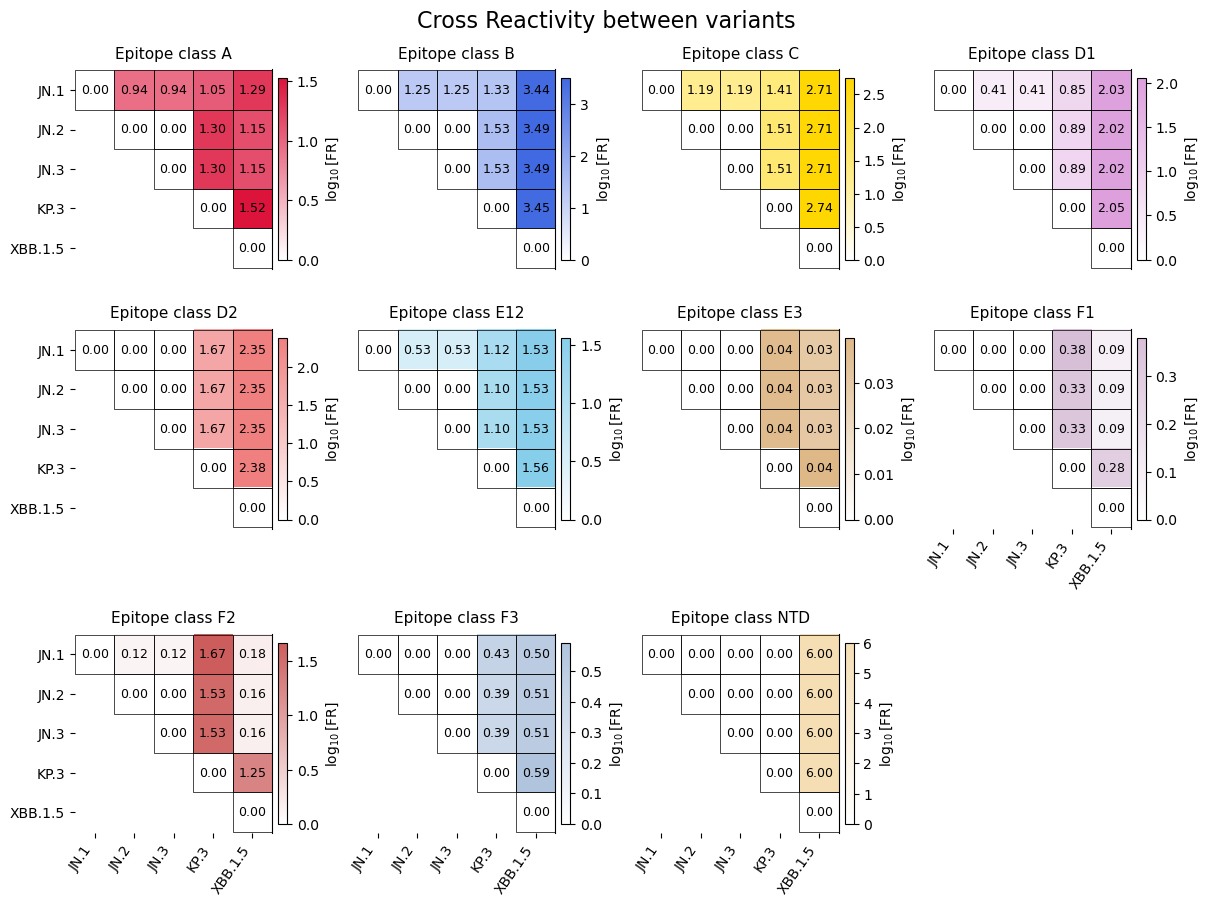

In [19]:
# Plot heatmaps for all epitopes
fig, axes = plt.subplots(3, 4, figsize=(12, 9), constrained_layout=True)

row = 0
col = 0
        
for ab in epitopes:
    A_raw = FR_epitopes_dict[ab].to_numpy()
    A_raw[A_raw <= 0] = np.nan  # Avoid log10(0) or log10(negative)
    A = np.log10(A_raw)
    im = upper_tri_heatmap(axes[row, col], A, labels, f"Epitope class {ab}", cmap=cmap[ab], vmin=0, vmax=np.nanmax(A))
    im.set_clim(0, np.nanmax(A))
    fig.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.03).set_label(r'$\log_{10}[\mathrm{FR}]$')
    # for spine in axes[row, col].spines.values():
    #     spine.set_visible(False)
    axes[row, col].spines['bottom'].set_visible(False)
    axes[row, col].spines['top'].set_visible(False)
    axes[row, col].spines['left'].set_visible(False)
    # If column % 4 < 3, no y-axis labels
    if col > 0:
        axes[row, col].set_yticklabels([])
        axes[row, col].set_yticks([])
    # If row < 2, no x-axis labels
    if (row < 2) and not ((col == 3) and (row == 1)):
        axes[row, col].set_xticklabels([])
        axes[row, col].set_xticks([])
    col += 1
    if col == 4:
        col = 0
        row += 1

axes[-1, -1].axis('off')
fig.suptitle("Cross Reactivity between variants", fontsize=16)
fig.subplots_adjust(top=0.9)
# fig.tight_layout()

if not os.path.exists("../../figures"):
    os.makedirs("../../figures")
    
fig.savefig("../../figures/epitope_heatmaps.png", dpi=300)
plt.show()

## Immunological dynamics simulation

**Expected sterilizing immunity against variant y**

$$\mathbb{E}[{Immune}_y(t)] = \sum_{x \in \mathcal{X}} \int_{0}^t \pi_x(s) \cdot I(s) \cdot P_{Neut}(t-s, x, y) ds$$
where 
- $\mathcal{X}$ is the group of all variants infection history
- $\pi_x$ is the proportion of variants $x$, 
- $I$ is the infection timeline, 
- and $P_{Neut}$ is the Neutralization probability

**Expected number of susceptible to infection with variant y**

$$\mathbb{E}[S_y(t)] = Pop - \mathbb{E}[Immune_y(t)]$$

### 3.1. Data preparation

Example from the paper

In [21]:
investigate_variants = ["BA.2.X", "BA.4.X + BA.5.X + BE.1.1", "XBB.1.5.X + EG.1.X", "JN.1.X + BA.2.86.X", "KP.X", "BF.7.X", "BQ.1.1.X", "XBB.1.9.X", "EG.5.X"]
# Remove .X at the end of each variant name
search_variants = [["BA.2"], ["BA.4", "BA.5", "BE.1.1"], ["XBB.1.5", "EG.1"], ["JN.1", "BA.2.86"], ["KP"], ["BF.7"], ["BQ.1.1"], ["XBB.1.9"], ["EG.5"]]
dfProf_w_variants = pd.read_csv("../../data/input/test_Germany/variant_proportion.csv")

# Initialize an empty dataframe to store the summed data
summed_data = pd.DataFrame(columns=dfProf_w_variants.columns.tolist())
summed_data = summed_data.rename(columns={summed_data.columns[0]:"Groups"})

# Create a list with only the variants of interest
for index, item in enumerate(search_variants):
    # print(item)
    temp_variants = []
    for variant in item:
        # If variant = "BA.2", don't include "BA.2.86"
        if variant == "BA.2":
            temp_variants += [v for v in dfProf_w_variants["Unnamed: 0"].to_list() if (variant in v) and ("BA.2.86" not in v)]
        else:
            temp_variants += [v for v in dfProf_w_variants["Unnamed: 0"].to_list() if variant in v]
    # print(temp_variants)
    temp_data = dfProf_w_variants[dfProf_w_variants["Unnamed: 0"].isin(temp_variants)]
    temp_data = temp_data.rename(columns={temp_data.columns[0]:"Groups"})
    temp_data["Groups"] = investigate_variants[index]
    summed_data = pd.concat([summed_data, pd.DataFrame(temp_data.sum(axis=0)).T], ignore_index=True)
    summed_data.at[summed_data.index[-1], "Groups"] = investigate_variants[index]
    summed_data.at[summed_data.index[-1], "Variants"] = ", ".join(temp_variants)
summed_data

,Groups,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,...,2024-06-25,2024-06-26,2024-06-27,2024-06-28,2024-06-29,2024-06-30,2024-07-01,2024-07-02,2024-07-03,Variants
0,BA.2.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"BA.2.10.3, BA.2.11, BA.2.12.1, BA.2.13, BA.2.1..."
1,BA.4.X + BA.5.X + BE.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"BA.4.1.8, BA.4.7, BA.4, BA.5.1.10, BA.5.1.28, ..."
2,XBB.1.5.X + EG.1.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"XBB.1.5.12, XBB.1.5.17, XBB.1.5.24, XBB.1.5.47..."
3,JN.1.X + BA.2.86.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312102,0.298618,0.285106,0.271565,0.257996,0.244397,0.230769,0.226018,0.22029,"JN.1.1.2, JN.1.1.3, JN.1.1.4, JN.1.1.6, JN.1.1..."
4,KP.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.675159,0.687566,0.7,0.71246,0.724947,0.73746,0.75,0.755585,0.762319,"KP.2.10, KP.2.3.2, KP.2.3, KP.3.1.4, KP.3.1, K..."
5,BF.7.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BF.7.1
6,BQ.1.1.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"BQ.1.1.1, BQ.1.1.13, BQ.1.1.19, BQ.1.1.2, BQ.1..."
7,XBB.1.9.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"XBB.1.9, XBB.1.9.2"
8,EG.5.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"EG.5.1.1, EG.5.1.11, EG.5.1.6, EG.5.1.8, EG.5.1"


Data in our project tasks

In [24]:
# "JN.1", "JN.2", "JN.3", "KP.3", "XBB.1.5"

investigate_variants = ["JN.1.X", "JN.2.X", "JN.3.X", "KP.3.X", "XBB.1.5.X"]
# Remove .X at the end of each variant name
search_variants = [["JN.1"], ["JN.2"], ["JN.3"], ["KP.3"], ["XBB.1.5"]]
dfProf_w_variants = pd.read_csv("../../data/input/test_Germany/variant_proportion.csv")

# Initialize an empty dataframe to store the summed data
summed_data = pd.DataFrame(columns=dfProf_w_variants.columns.tolist())
summed_data = summed_data.rename(columns={summed_data.columns[0]:"Groups"})

# Create a list with only the variants of interest
for index, item in enumerate(search_variants):
    # print(item)
    temp_variants = []
    for variant in item:
        # If variant = "BA.2", don't include "BA.2.86"
        if variant == "BA.2":
            temp_variants += [v for v in dfProf_w_variants["Unnamed: 0"].to_list() if (variant in v) and ("BA.2.86" not in v)]
        else:
            temp_variants += [v for v in dfProf_w_variants["Unnamed: 0"].to_list() if variant in v]
    # print(temp_variants)
    temp_data = dfProf_w_variants[dfProf_w_variants["Unnamed: 0"].isin(temp_variants)]
    temp_data = temp_data.rename(columns={temp_data.columns[0]:"Groups"})
    temp_data["Groups"] = search_variants[index][0]
    summed_data = pd.concat([summed_data, pd.DataFrame(temp_data.sum(axis=0)).T], ignore_index=True)
    summed_data.at[summed_data.index[-1], "Groups"] = search_variants[index][0]
    summed_data.at[summed_data.index[-1], "Variants"] = ", ".join(temp_variants)
summed_data

,Groups,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,...,2024-06-25,2024-06-26,2024-06-27,2024-06-28,2024-06-29,2024-06-30,2024-07-01,2024-07-02,2024-07-03,Variants
0,JN.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.302548,0.285866,0.269149,0.252396,0.235608,0.218783,0.201923,0.198423,0.194203,"JN.1.1.2, JN.1.1.3, JN.1.1.4, JN.1.1.6, JN.1.1..."
1,JN.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JN.2
2,JN.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JN.3.1
3,KP.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.570064,0.575983,0.581915,0.587859,0.593817,0.599787,0.605769,0.611038,0.617391,"KP.3.1.4, KP.3.1, KP.3"
4,XBB.1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"XBB.1.5.12, XBB.1.5.17, XBB.1.5.24, XBB.1.5.47..."


In [25]:
# Create new proportion dataframe with the variants of interest and germany data

# Change column name from "Groups" to "Unnamed: 0" to be consistent with dfProf_w_variants
summed_data_2 = summed_data.copy()
summed_data_2 = summed_data_2.rename(columns={"Groups":"Unnamed: 0"})
# Remove the "Variants" column before saving
summed_data_2 = summed_data_2.drop(columns=["Variants"])

# Remove variants found by search pattern in the dfProf_w_variants and add the summed_data at the end
to_remove = []
for item in search_variants:
    for variant in item:
        if variant == "BA.2":
            to_remove += [v for v in dfProf_w_variants["Unnamed: 0"].to_list() if (variant in v) and ("BA.2.86" not in v)]
        else:
            to_remove += [v for v in dfProf_w_variants["Unnamed: 0"].to_list() if variant in v]
dfProf_w_variants_2 = dfProf_w_variants[~dfProf_w_variants["Unnamed: 0"].isin(to_remove)]
dfProf_w_variants_2 = pd.concat([dfProf_w_variants_2, summed_data_2], ignore_index=True)
dfProf_w_variants_2.to_csv("../../data/input/test_Germany/variant_proportion_new.csv", index=False)

### Data check

In [30]:
# Let's examine what's in the cross-reactivity dictionary vs what we're looking for
print("Variants in Cross_dic (variant_list2):")
print(Cross_dic["variant_list2"])
print("\nVariants in timeline from Germany data:")
print(variants_in_timeline_Germany)
print("\nLooking for variant:", group)

Variants in Cross_dic (variant_list2):
['JN.1', 'JN.2', 'JN.3', 'KP.3', 'XBB.1.5']

Variants in timeline from Germany data:
['AY.100', 'AY.106', 'AY.33', 'AY.33.2', 'AY.4.2', 'AY.41', 'AY.51', 'AY.68', 'AY.98.1', 'AZ.2', 'B.1.1.317', 'B.1.1.523', 'B.1.1.529', 'B.1.1.7', 'B.1.177.75', 'B.1.177', 'B.1.221', 'B.1.258', 'B.1.351', 'B.1.619', 'B.1.620', 'B.1.621', 'B', 'BA.1.1.15', 'BA.1.1', 'BA.1', 'BA.2.10.3', 'BA.2.11', 'BA.2.12.1', 'BA.2.13', 'BA.2.16', 'BA.2.18', 'BA.2.3.20', 'BA.2.48', 'BA.2.52', 'BA.2.86', 'BA.2.86.1', 'BA.2.86.6', 'BA.2', 'BA.4.1.8', 'BA.4.7', 'BA.4', 'BA.5.1.10', 'BA.5.1.28', 'BA.5.2.14', 'BA.5.2.18', 'BA.5.2.25', 'BA.5.2.32', 'BA.5.2.36', 'BA.5.9', 'BE.10', 'BF.1', 'BF.5.5', 'BF.7.1', 'BN.1.2.3', 'BN.1.2', 'BN.1.4.1', 'BN.1', 'BN.3.1', 'BQ.1.1.1', 'BQ.1.1.13', 'BQ.1.1.19', 'BQ.1.1.2', 'BQ.1.1.31', 'BQ.1.1.37', 'BQ.1.1.45', 'BQ.1.1.46', 'BQ.1.1.47', 'BQ.1.1', 'BQ.1.13.1', 'BQ.1.23', 'BQ.1.25', 'BR.1', 'BR.2', 'BU.3', 'C.36.3', 'C.36.3.1', 'C.37.1', 'CH.1.1.1', 'CH.

In [31]:
# Let's check what's in the Germany cross-reactivity dictionary
print("Variants in Cross_dic_Germany (variant_list2):")
print(Cross_dic_Germany["variant_list2"])

Variants in Cross_dic_Germany (variant_list2):
['AY.100', 'AY.106', 'AY.33', 'AY.33.2', 'AY.4.2', 'AY.41', 'AY.51', 'AY.68', 'AY.98.1', 'AZ.2', 'B.1.1.317', 'B.1.1.523', 'B.1.1.529', 'B.1.1.7', 'B.1.177.75', 'B.1.177', 'B.1.221', 'B.1.258', 'B.1.351', 'B.1.619', 'B.1.620', 'B.1.621', 'B', 'BA.1.1.15', 'BA.1.1', 'BA.1', 'BA.2.10.3', 'BA.2.11', 'BA.2.12.1', 'BA.2.13', 'BA.2.16', 'BA.2.18', 'BA.2.3.20', 'BA.2.48', 'BA.2.52', 'BA.2.86', 'BA.2.86.1', 'BA.2.86.6', 'BA.2', 'BA.4.1.8', 'BA.4.7', 'BA.4', 'BA.5.1.10', 'BA.5.1.28', 'BA.5.2.14', 'BA.5.2.18', 'BA.5.2.25', 'BA.5.2.32', 'BA.5.2.36', 'BA.5.9', 'BE.10', 'BF.1', 'BF.5.5', 'BF.7.1', 'BN.1.2.3', 'BN.1.2', 'BN.1.4.1', 'BN.1', 'BN.3.1', 'BQ.1.1.1', 'BQ.1.1.13', 'BQ.1.1.19', 'BQ.1.1.2', 'BQ.1.1.31', 'BQ.1.1.37', 'BQ.1.1.45', 'BQ.1.1.46', 'BQ.1.1.47', 'BQ.1.1', 'BQ.1.13.1', 'BQ.1.23', 'BQ.1.25', 'BR.1', 'BR.2', 'BU.3', 'C.36.3', 'C.36.3.1', 'C.37.1', 'CH.1.1.1', 'CH.1.1.12', 'CH.1.1.15', 'CH.1.1.18', 'CH.1.1.30', 'CH.1.1', 'CJ.1.3', 'CJ.1', '

Since there are some variants in the timeline that are not in the cross-reactivity dictionary, we sticked to the original proportion file for Germany without aggregating variants.

In [107]:
#Cross_dic_Germany

In [34]:
summed_data["Variants"][0].split(", ")

['JN.1.1.2',
 'JN.1.1.3',
 'JN.1.1.4',
 'JN.1.1.6',
 'JN.1.11.1',
 'JN.1.13.1',
 'JN.1.13',
 'JN.1.15',
 'JN.1.16.1',
 'JN.1.16.3',
 'JN.1.18',
 'JN.1.18.2',
 'JN.1.18.3',
 'JN.1.18.5',
 'JN.1.29',
 'JN.1.50',
 'JN.10',
 'JN.11',
 'JN.12']

### Relative fitness of some variants

**Variant dynamics**

To estimate whether an emerging variant may successfully out-compete existing variants, we estimated the relative growth advantage of a variant $\gamma_y(t)$:

$$
\gamma_y(t) = 
\frac{
\alpha_y \, \mathbb{E}[S_y(t)] - 
\sum_{x \in \mathcal{X}} \pi_x(t) \, \alpha_x \, \mathbb{E}[S_x(t)]
}{
\sum_{x \in \mathcal{X}} \pi_x(t) \, \alpha_x \, \mathbb{E}[S_x(t)]
},
$$

in which the denominator denotes the average growth rate across all variants existing at time $t$ and for which $\alpha_x > 0$ denotes a variant’s intrinsic (antibody-independent) relative transmission fitness, which we assumed to be nearly identical for all circulating variants $\alpha_x \approx \alpha$, implying that variant dynamics are dominated by infection history and immune dynamics. We ignored low-abundance variants with $\pi_x(t) < 1\%$ and renormalized accordingly. We computed the frequency-weighted average $\gamma_{\mathcal{X}}(t)$ whenever different variants were combined during analyses (as indicated in the respective graphics).


In [70]:
"""Project 5: Question 2) Compute number of susceptible for major variants in Germany listed bellow"""

### provide infection data
dfI = pd.read_csv("../../data/input/test_Germany/infection_data.csv")
infection_data_Germany_orig = dfI["num_infected"].to_numpy()
PopG = 84334787.0 ### total population for Germany


### load dates ###
dates = dfI["Unnamed: 0"].to_list() ### or to_numpy() if you want a numpy array

#### restrict simulation timeframe infection data
start_sim = "2021-07-01"
end_sim = "2024-07-03"

# restict infection timeline
start = dates.index(start_sim)
end = dates.index(end_sim)
infection_data_Germany = infection_data_Germany_orig[start:end+1]
dates = dates[start:end+1]
### provide variant proportion timeline, each row represents the variant corresponding to variants_in_timeline
# NB: if cross-reactivity file is asymetric, variants_in_timeline has to be a subset of lineage_list_2 
# But here it does not matter because we computed a symetrical cross-reactivity
dfProp = pd.read_csv("../../data/input/test_Germany/variant_proportion.csv")

variants_in_timeline_Germany = dfProp["Unnamed: 0"].to_list()

#remove irrelevant column
dfProp.drop(columns = ["Unnamed: 0"], inplace = True)
date_prop = dfProp.columns.to_list()
start1 = date_prop.index(start_sim)
end1 = date_prop.index(end_sim)
variant_proportion_Germany = dfProp.to_numpy()[:, start1:end1+1] # rows corresponds to variants and columns to timepoints 


### load Cross reactivity dictionary (already given in dataset) ####
import pickle
file = open("../../data/input/test_Germany/Cross_react_Germany.pck", "rb")
Cross_dic_Germany= pickle.load(file)
file.close()


### Choose one of the 75 combination of pharmacokinetics parameter
PK_params = list(PK_dframe.columns)
ind = 1 ### as  an example
PK_trend = PK_dframe[PK_params[ind]].to_numpy()

In [ ]:
"""Evaluate relative number of Susceptible"""

def gamma_y(S, pS_mean):
    return np.divide(S - pS_mean, pS_mean, out = np.zeros(len(S)), where = pS_mean != 0.)

### compute S_timeline, the vector containing the expected number of susceptible for each parameter PK

group = "BA.2"
fitnesses = []

for param in PK_params[:20]:  # Just to limit the number of computations for demonstration purposes

    S_timeline_Germany = []
    
    PK_trend = PK_dframe[param].to_numpy()

    Exp_I_BA2 = Immune_dynamics(PK_trend, 
                                infection_data_Germany, 
                                tested_variant = group, 
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)


    ### Compare fitnesses
    Exp_Susc_group = PopG - Exp_I_BA2
    print("Simulation for %s"%param)
    print("Expected Susceptible for %s"%group, Exp_Susc_group)

    for i in range(len(variants_in_timeline_Germany)):
        Ei = Immune_dynamics(PK_trend,
                              infection_data_Germany,
                              tested_variant=variants_in_timeline_Germany[i],  ### here compute for variants that are in timeline
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)
    
        Res = PopG - Ei
        S_timeline_Germany.append(Res)

    pS_mean = np.sum(variant_proportion_Germany*np.array(S_timeline_Germany), axis = 0)

    ### compute gamma for BA.2
    gBA2 = gamma_y(Exp_Susc_group, pS_mean)
    fitnesses.append(gBA2)

    ### Compare relative fitnesses
    print("Simulation for %s"%param)
    print("Relative fitness for %s"%group, gBA2)

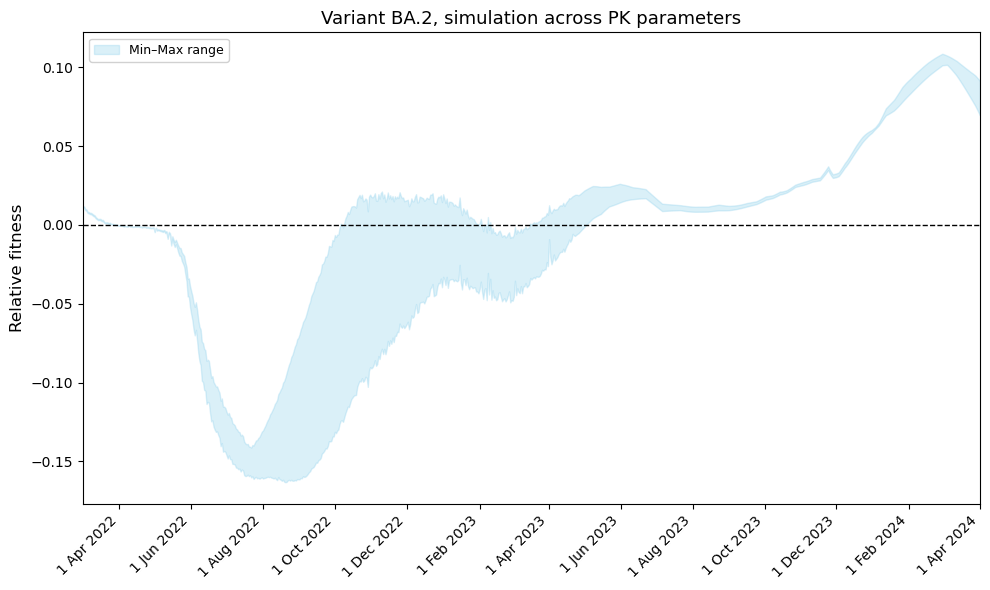

In [73]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array_BA2 = np.asarray(fitnesses)            # shape: (n_PK, T)
min_vals = fitness_array_BA2.min(axis=0)
max_vals = fitness_array_BA2.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2022-03-01"
day_max = "2024-04-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="skyblue", alpha=0.3, label="Min–Max range")
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper left")

plt.tight_layout()
# fig.savefig("relative_fitness_band.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


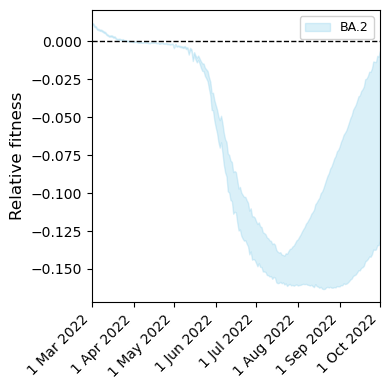

In [88]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array = np.asarray(fitnesses)            # shape: (n_PK, T)
min_vals = fitness_array.min(axis=0)
max_vals = fitness_array.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2022-03-01"
day_max = "2022-10-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(4, 4))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="skyblue", alpha=0.3, label=group)
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
# ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 1 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper right")

plt.tight_layout()
fig.savefig("../../figures/relative_fitness_BA2.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array = np.asarray(fitnesses)            # shape: (n_PK, T)
min_vals = fitness_array.min(axis=0)
max_vals = fitness_array.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2022-03-01"
day_max = "2024-04-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="skyblue", alpha=0.3, label="Min–Max range")
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper left")

plt.tight_layout()
# fig.savefig("relative_fitness_band.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


In [ ]:
"""Evaluate relative number of Susceptible"""

def gamma_y(S, pS_mean):
    return np.divide(S - pS_mean, pS_mean, out = np.zeros(len(S)), where = pS_mean != 0.)

### compute S_timeline, the vector containing the expected number of susceptible for each parameter PK

group = "BA.4"
fitnesses = []

for param in PK_params[:20]:  # Just to limit the number of computations for demonstration purposes

    S_timeline_Germany = []
    
    PK_trend = PK_dframe[param].to_numpy()

    Exp_I_JN = Immune_dynamics(PK_trend, 
                                infection_data_Germany, 
                                tested_variant = group, 
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)


    ### Compare fitnesses
    Exp_Susc_group = PopG - Exp_I_JN
    print("Simulation for %s"%param)
    print("Expected Susceptible for %s"%group, Exp_Susc_group)

    for i in range(len(variants_in_timeline_Germany)):
        Ei = Immune_dynamics(PK_trend,
                              infection_data_Germany,
                              tested_variant=variants_in_timeline_Germany[i],  ### here compute for variants that are in timeline
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)
    
        Res = PopG - Ei
        S_timeline_Germany.append(Res)

    pS_mean = np.sum(variant_proportion_Germany*np.array(S_timeline_Germany), axis = 0)

    ### compute gamma for JN.1.1.2
    gJN = gamma_y(Exp_Susc_group, pS_mean)
    fitnesses.append(gJN)

    ### Compare relative fitnesses
    print("Simulation for %s"%param)
    print("Relative fitness for %s"%group, gJN)

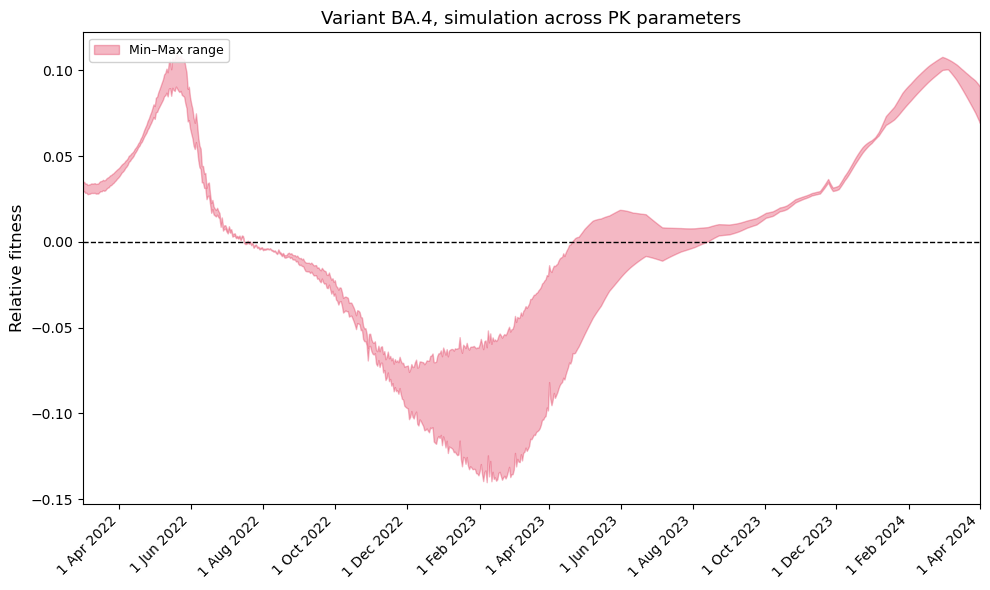

In [78]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array = np.asarray(fitnesses)            # shape: (n_PK, T)
min_vals = fitness_array.min(axis=0)
max_vals = fitness_array.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2022-03-01"
day_max = "2024-04-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="crimson", alpha=0.3, label="Min–Max range")
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper left")

plt.tight_layout()
# fig.savefig("relative_fitness_band.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


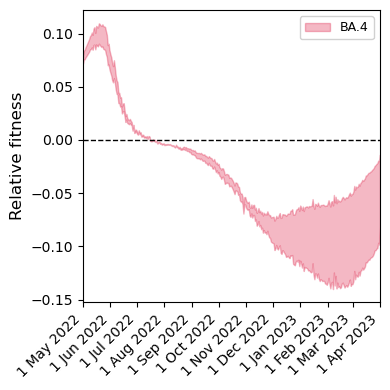

In [86]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array = np.asarray(fitnesses)            # shape: (n_PK, T)
min_vals = fitness_array.min(axis=0)
max_vals = fitness_array.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2022-05-01"
day_max = "2023-04-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(4, 4))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="crimson", alpha=0.3, label=group)
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
# ax.set_title(f"Variant {group}", fontsize=13)

# date ticks every 1 month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper right")

plt.tight_layout()
fig.savefig("../../figures/relative_fitness_band_BA4.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


In [ ]:
"""Evaluate relative number of Susceptible"""

def gamma_y(S, pS_mean):
    return np.divide(S - pS_mean, pS_mean, out = np.zeros(len(S)), where = pS_mean != 0.)

### compute S_timeline, the vector containing the expected number of susceptible for each parameter PK

group = "XBB.1.5.12"
fitnesses_XBB = []

for param in PK_params[:20]:  # Just to limit the number of computations for demonstration purposes

    S_timeline_Germany = []
    
    PK_trend = PK_dframe[param].to_numpy()

    Exp_I_JN = Immune_dynamics(PK_trend, 
                                infection_data_Germany, 
                                tested_variant = group, 
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)


    ### Compare fitnesses
    Exp_Susc_group = PopG - Exp_I_JN
    print("Simulation for %s"%param)
    print("Expected Susceptible for %s"%group, Exp_Susc_group)

    for i in range(len(variants_in_timeline_Germany)):
        Ei = Immune_dynamics(PK_trend,
                              infection_data_Germany,
                              tested_variant=variants_in_timeline_Germany[i],  ### here compute for variants that are in timeline
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)
    
        Res = PopG - Ei
        S_timeline_Germany.append(Res)

    pS_mean = np.sum(variant_proportion_Germany*np.array(S_timeline_Germany), axis = 0)

    ### compute gamma for XBB.1.5.12
    gXBB = gamma_y(Exp_Susc_group, pS_mean)
    fitnesses_XBB.append(gXBB)

    ### Compare relative fitnesses
    print("Simulation for %s"%param)
    print("Relative fitness for %s"%group, gXBB)

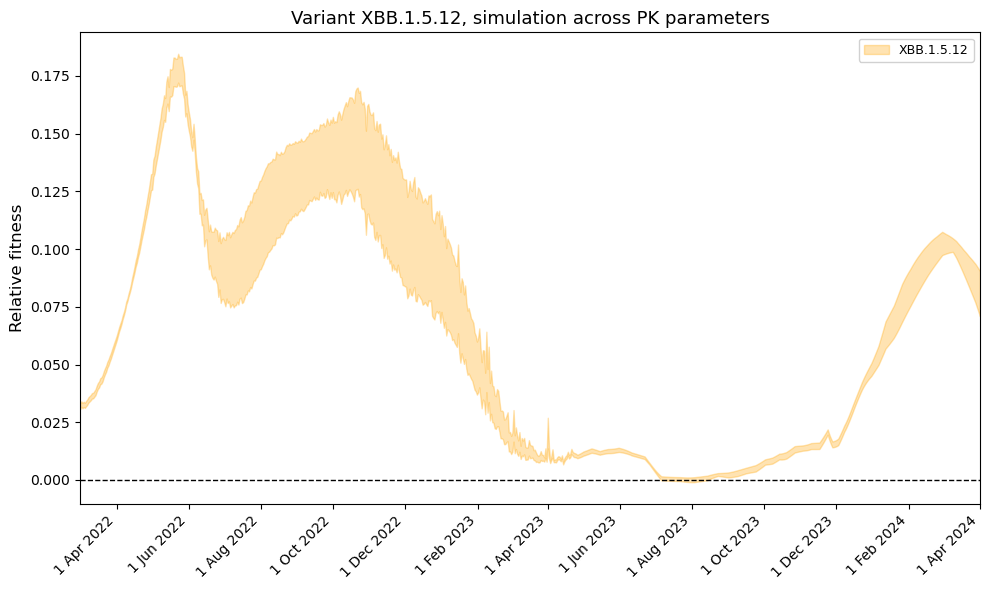

In [90]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array_XBB = np.asarray(fitnesses_XBB)            # shape: (n_PK, T)
min_vals = fitness_array_XBB.min(axis=0)
max_vals = fitness_array_XBB.max(axis=0)
# med_vals = np.median(fitness_array_XBB, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2022-03-01"
day_max = "2024-04-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="orange", alpha=0.3, label=group)
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper right")

plt.tight_layout()
# fig.savefig("relative_fitness_band.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


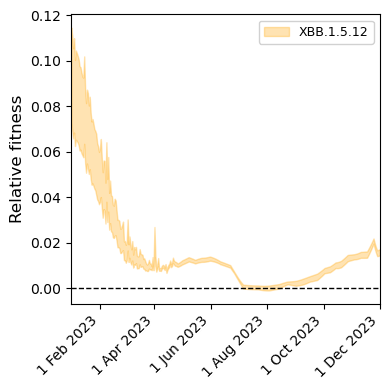

In [93]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array_XBB = np.asarray(fitnesses_XBB)            # shape: (n_PK, T)
min_vals = fitness_array_XBB.min(axis=0)
max_vals = fitness_array_XBB.max(axis=0)
# med_vals = np.median(fitness_array_XBB, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2023-01-01"
day_max = "2023-12-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(4, 4))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="orange", alpha=0.3, label=group)
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
# ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper right")

plt.tight_layout()
fig.savefig("../../figures/relative_fitness_band_XBB1512.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


In [ ]:
"""Evaluate relative number of Susceptible"""

def gamma_y(S, pS_mean):
    return np.divide(S - pS_mean, pS_mean, out = np.zeros(len(S)), where = pS_mean != 0.)

### compute S_timeline, the vector containing the expected number of susceptible for each parameter PK

group = "JN.1.1.2"
fitnesses_JN1 = []

for param in PK_params[:20]:  # Just to limit the number of computations for demonstration purposes

    S_timeline_Germany = []
    
    PK_trend = PK_dframe[param].to_numpy()

    Exp_I_JN = Immune_dynamics(PK_trend, 
                                infection_data_Germany, 
                                tested_variant = group, 
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)


    ### Compare fitnesses
    Exp_Susc_group = PopG - Exp_I_JN
    print("Simulation for %s"%param)
    print("Expected Susceptible for %s"%group, Exp_Susc_group)

    for i in range(len(variants_in_timeline_Germany)):
        Ei = Immune_dynamics(PK_trend,
                              infection_data_Germany,
                              tested_variant=variants_in_timeline_Germany[i],  ### here compute for variants that are in timeline
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)
    
        Res = PopG - Ei
        S_timeline_Germany.append(Res)

    pS_mean = np.sum(variant_proportion_Germany*np.array(S_timeline_Germany), axis = 0)

    ### compute gamma for JN.1.1.2
    gJN = gamma_y(Exp_Susc_group, pS_mean)
    fitnesses_JN1.append(gJN)

    ### Compare relative fitnesses
    print("Simulation for %s"%param)
    print("Relative fitness for %s"%group, gJN)

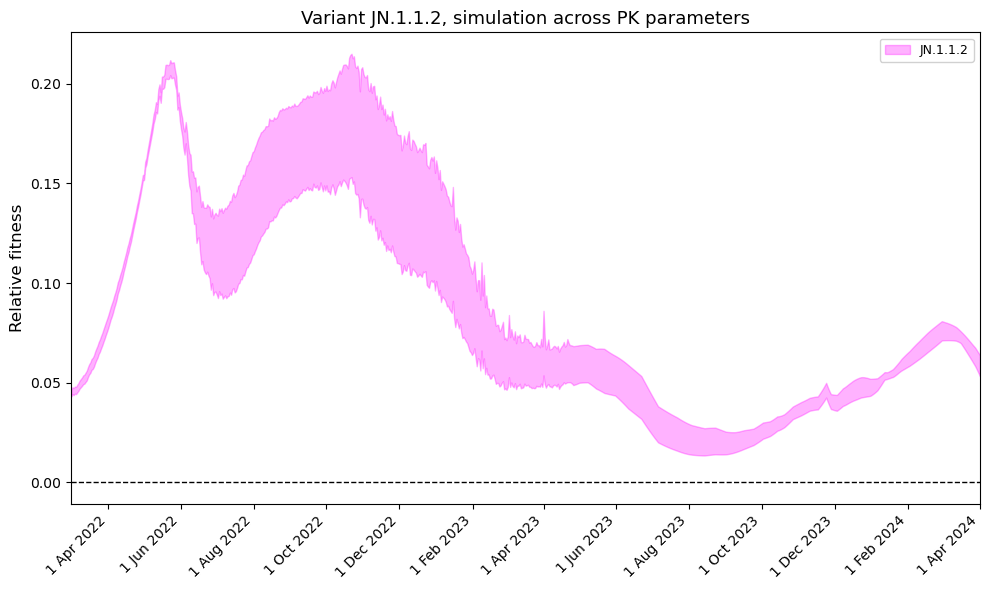

In [97]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array_JN1 = np.asarray(fitnesses_JN1)            # shape: (n_PK, T)
min_vals = fitness_array_JN1.min(axis=0)
max_vals = fitness_array_JN1.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2022-03-01"
day_max = "2024-04-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="magenta", alpha=0.3, label=group)
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper right")

plt.tight_layout()
# fig.savefig("relative_fitness_band.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


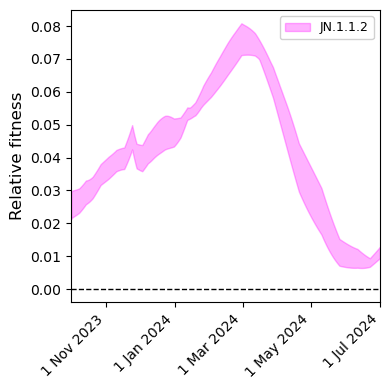

In [101]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array_JN1 = np.asarray(fitnesses_JN1)            # shape: (n_PK, T)
min_vals = fitness_array_JN1.min(axis=0)
max_vals = fitness_array_JN1.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2023-10-01"
day_max = "2024-07-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(4, 4))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="magenta", alpha=0.3, label=group)
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
# ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper right")

plt.tight_layout()
fig.savefig("../../figures/relative_fitness_band_JN112.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


In [ ]:
"""Evaluate relative number of Susceptible"""

def gamma_y(S, pS_mean):
    return np.divide(S - pS_mean, pS_mean, out = np.zeros(len(S)), where = pS_mean != 0.)

### compute S_timeline, the vector containing the expected number of susceptible for each parameter PK

group = "KP.3"
fitnesses_KP3 = []

for param in PK_params[:20]:  # Just to limit the number of computations for demonstration purposes

    S_timeline_Germany = []
    
    PK_trend = PK_dframe[param].to_numpy()

    Exp_I_KP3 = Immune_dynamics(PK_trend, 
                                infection_data_Germany, 
                                tested_variant = group, 
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)


    ### Compare fitnesses
    Exp_Susc_group = PopG - Exp_I_KP3
    print("Simulation for %s"%param)
    print("Expected Susceptible for %s"%group, Exp_Susc_group)

    for i in range(len(variants_in_timeline_Germany)):
        Ei = Immune_dynamics(PK_trend,
                              infection_data_Germany,
                              tested_variant=variants_in_timeline_Germany[i],  ### here compute for variants that are in timeline
                                variants_in_timeline = variants_in_timeline_Germany, 
                                variant_proportion = variant_proportion_Germany, 
                                Ab_classes = epitopes,      
                                IC50xx_dic = IC50xx_dic, 
                                Cross_react_dic = Cross_dic_Germany)
    
        Res = PopG - Ei
        S_timeline_Germany.append(Res)

    pS_mean = np.sum(variant_proportion_Germany*np.array(S_timeline_Germany), axis = 0)

    ### compute gamma for KP.3
    gKP3 = gamma_y(Exp_Susc_group, pS_mean)
    fitnesses_KP3.append(gKP3)

    ### Compare relative fitnesses
    print("Simulation for %s"%param)
    print("Relative fitness for %s"%group, gKP3)

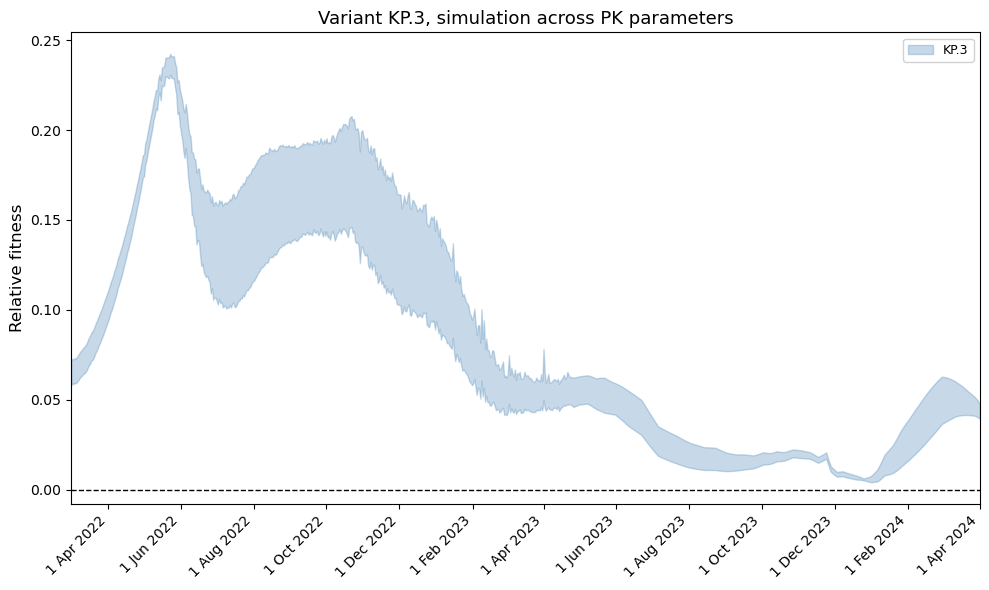

In [103]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array_KP3 = np.asarray(fitnesses_KP3)            # shape: (n_PK, T)
min_vals = fitness_array_KP3.min(axis=0)
max_vals = fitness_array_KP3.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2022-03-01"
day_max = "2024-04-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="steelblue", alpha=0.3, label=group)
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 2 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper right")

plt.tight_layout()
# fig.savefig("relative_fitness_band.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


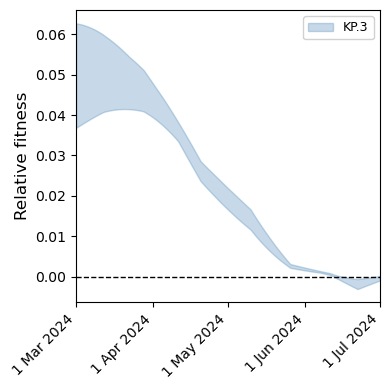

In [105]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# --- prepare data ---
fitness_array_KP3 = np.asarray(fitnesses_KP3)            # shape: (n_PK, T)
min_vals = fitness_array_KP3.min(axis=0)
max_vals = fitness_array_KP3.max(axis=0)
# med_vals = np.median(fitness_array, axis=0)      # (use median; change to mean if you prefer)

date_cols = dfI["Unnamed: 0"].to_list()[start:end+1]
dates = pd.to_datetime(date_cols)

# --- choose the plotting window (by date strings) ---
day_min = "2024-03-01"
day_max = "2024-07-01"
mask = (dates >= pd.to_datetime(day_min)) & (dates <= pd.to_datetime(day_max))

# --- plot ---
fig, ax = plt.subplots(figsize=(4, 4))

# band and central curve
ax.fill_between(dates[mask], min_vals[mask], max_vals[mask],
                color="steelblue", alpha=0.3, label=group)
# ax.plot(dates[mask], med_vals[mask], color="steelblue", lw=2.5, label="Median")

# zero line
ax.axhline(0, ls="--", color="black", lw=1)

# cosmetics
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
# ax.set_ylim(-0.25, 0.10)  # uncomment if you want a fixed y-range
ax.set_ylabel("Relative fitness", fontsize=12)
# ax.set_title(f"Variant {group}, simulation across PK parameters", fontsize=13)

# date ticks every 1 month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(frameon=True, framealpha=0.9, fontsize=9, loc="upper right")

plt.tight_layout()
fig.savefig("../../figures/relative_fitness_band_KP3.png", dpi=300, bbox_inches="tight")  # optional export
plt.show()


In [50]:
summed_data

,Groups,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,...,2024-06-25,2024-06-26,2024-06-27,2024-06-28,2024-06-29,2024-06-30,2024-07-01,2024-07-02,2024-07-03,Variants
0,JN.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.302548,0.285866,0.269149,0.252396,0.235608,0.218783,0.201923,0.198423,0.194203,"JN.1.1.2, JN.1.1.3, JN.1.1.4, JN.1.1.6, JN.1.1..."
1,JN.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JN.2
2,JN.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JN.3.1
3,KP.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.570064,0.575983,0.581915,0.587859,0.593817,0.599787,0.605769,0.611038,0.617391,"KP.3.1.4, KP.3.1, KP.3"
4,XBB.1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"XBB.1.5.12, XBB.1.5.17, XBB.1.5.24, XBB.1.5.47..."


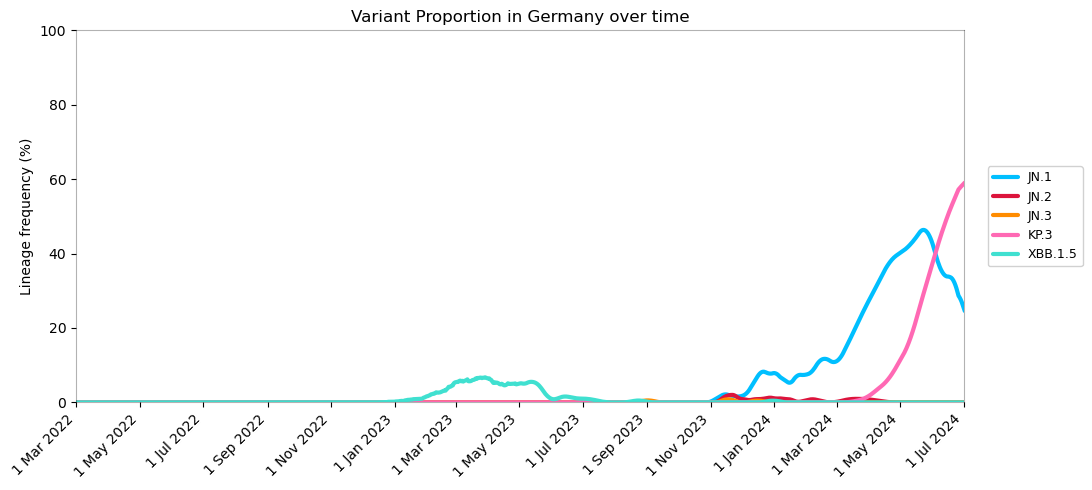

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

day_min = "2022-03-01"
day_max = "2024-07-01"

colors = {
    "JN.1": "deepskyblue",
    "JN.2": "crimson",
    "JN.3": "darkorange",
    "KP.3": "hotpink",
    "XBB.1.5": "turquoise",
}

# dv = {k: (pd.to_datetime(v[0]), pd.to_datetime(v[1])) for k, v in day_variants.items()}

# Smoothing parameters to make plot looks like the one in the paper
win_mean = 14
win_band = 28
band_k   = 1.5

date_cols = summed_data.columns[1:-2]
dates = pd.to_datetime(date_cols)

fig, ax = plt.subplots(figsize=(13, 5))

for i in range(len(summed_data)):
    label = summed_data.iloc[i, 0]
    color = colors.get(label, None)
    y = pd.Series(summed_data.iloc[i, 1:-2].astype(float).values, index=dates)
    y_mean = y.rolling(win_mean, center=True, min_periods=1).mean()
    ax.plot(dates, 100*y_mean, color=color, lw=3, label=label, solid_capstyle="round")

# Cosmetics
ax.set_ylim(0, 100)
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
ax.set_ylabel("Lineage frequency (%)")
ax.set_title("Variant Proportion in Germany over time")
ax.grid(False)

# Date formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for spine in ax.spines.values():
    spine.set_alpha(0.3)

# Move legend outside plot area (right side)
ax.legend(
    loc="center left",             # anchor to the left of the legend box
    bbox_to_anchor=(1.02, 0.5),    # (x, y) coordinates relative to axes
    frameon=True,
    framealpha=0.9,
    fontsize=9
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend on the right

plt.savefig("../../figures/lineage-frequency.png", dpi=300, bbox_inches="tight")
plt.show()

In [63]:
investigate_variants = ["BA.2.X", "BA.4.X + BA.5.X + BE.1.1", "XBB.1.5.X + EG.1.X", "JN.1.X + BA.2.86.X", "KP.X", "BF.7.X", "BQ.1.1.X", "XBB.1.9.X", "EG.5.X"]
# Remove .X at the end of each variant name
search_variants = [["BA.2"], ["BA.4", "BA.5", "BE.1.1"], ["XBB.1.5", "EG.1"], ["JN.1", "BA.2.86"], ["KP"], ["BF.7"], ["BQ.1.1"], ["XBB.1.9"], ["EG.5"]]
dfProf_w_variants = pd.read_csv("../../data/input/test_Germany/variant_proportion.csv")

# Initialize an empty dataframe to store the summed data
summed_data = pd.DataFrame(columns=dfProf_w_variants.columns.tolist())
summed_data = summed_data.rename(columns={summed_data.columns[0]:"Groups"})

# Create a list with only the variants of interest
for index, item in enumerate(search_variants):
    # print(item)
    temp_variants = []
    for variant in item:
        # If variant = "BA.2", don't include "BA.2.86"
        if variant == "BA.2":
            temp_variants += [v for v in dfProf_w_variants["Unnamed: 0"].to_list() if (variant in v) and ("BA.2.86" not in v)]
        else:
            temp_variants += [v for v in dfProf_w_variants["Unnamed: 0"].to_list() if variant in v]
    # print(temp_variants)
    temp_data = dfProf_w_variants[dfProf_w_variants["Unnamed: 0"].isin(temp_variants)]
    temp_data = temp_data.rename(columns={temp_data.columns[0]:"Groups"})
    temp_data["Groups"] = investigate_variants[index]
    summed_data = pd.concat([summed_data, pd.DataFrame(temp_data.sum(axis=0)).T], ignore_index=True)
    summed_data.at[summed_data.index[-1], "Groups"] = investigate_variants[index]
    summed_data.at[summed_data.index[-1], "Variants"] = ", ".join(temp_variants)
summed_data

,Groups,2021-02-01,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,...,2024-06-25,2024-06-26,2024-06-27,2024-06-28,2024-06-29,2024-06-30,2024-07-01,2024-07-02,2024-07-03,Variants
0,BA.2.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"BA.2.10.3, BA.2.11, BA.2.12.1, BA.2.13, BA.2.1..."
1,BA.4.X + BA.5.X + BE.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"BA.4.1.8, BA.4.7, BA.4, BA.5.1.10, BA.5.1.28, ..."
2,XBB.1.5.X + EG.1.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"XBB.1.5.12, XBB.1.5.17, XBB.1.5.24, XBB.1.5.47..."
3,JN.1.X + BA.2.86.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.312102,0.298618,0.285106,0.271565,0.257996,0.244397,0.230769,0.226018,0.22029,"JN.1.1.2, JN.1.1.3, JN.1.1.4, JN.1.1.6, JN.1.1..."
4,KP.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.675159,0.687566,0.7,0.71246,0.724947,0.73746,0.75,0.755585,0.762319,"KP.2.10, KP.2.3.2, KP.2.3, KP.3.1.4, KP.3.1, K..."
5,BF.7.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BF.7.1
6,BQ.1.1.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"BQ.1.1.1, BQ.1.1.13, BQ.1.1.19, BQ.1.1.2, BQ.1..."
7,XBB.1.9.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"XBB.1.9, XBB.1.9.2"
8,EG.5.X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"EG.5.1.1, EG.5.1.11, EG.5.1.6, EG.5.1.8, EG.5.1"


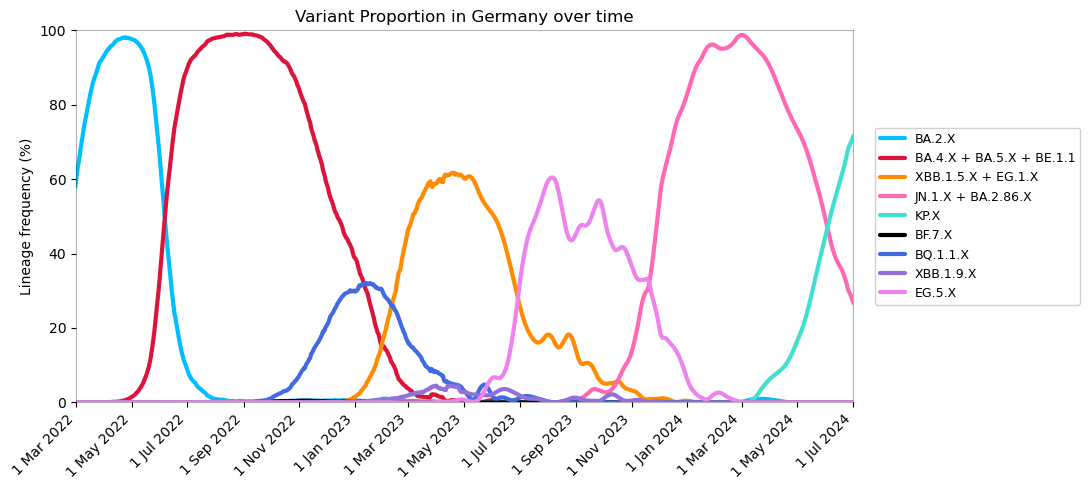

In [66]:
ay_min = "2022-03-01"
day_max = "2024-07-01"

day_variants = {
    "BA.2.X": ["2022-03-01", "2022-10-01"],
    "BA.4.X + BA.5.X + BE.1.1": ["2022-05-01", "2023-04-01"],
    "XBB.1.5.X + EG.1.X": ["2023-01-01", "2023-12-01"],
    "JN.1.X + BA.2.86.X": ["2023-10-01", "2024-07-01"],
    "KP.X": ["2024-03-01", "2024-07-01"],
    "BF.7.X": ["2022-09-01", "2023-03-01"],
    "BQ.1.1.X": ["2022-10-01", "2023-06-01"],
    "XBB.1.9.X": ["2023-03-01", "2023-08-01"],
    "EG.5.X": ["2023-06-01", "2024-02-01"],
}

colors = {
    "BA.2.X": "deepskyblue",
    "BA.4.X + BA.5.X + BE.1.1": "crimson",
    "XBB.1.5.X + EG.1.X": "darkorange",
    "JN.1.X + BA.2.86.X": "hotpink",
    "KP.X": "turquoise",
    "BF.7.X": "black",
    "BQ.1.1.X": "royalblue",
    "XBB.1.9.X": "mediumpurple",
    "EG.5.X": "violet",
}

dv = {k: (pd.to_datetime(v[0]), pd.to_datetime(v[1])) for k, v in day_variants.items()}

# Smoothing parameters to make plot looks like the one in the paper
win_mean = 14
win_band = 28
band_k   = 1.5

date_cols = summed_data.columns[1:-2]
dates = pd.to_datetime(date_cols)

fig, ax = plt.subplots(figsize=(13, 5))

for i in range(len(summed_data)):
    label = summed_data.iloc[i, 0]
    color = colors.get(label, None)
    y = pd.Series(summed_data.iloc[i, 1:-2].astype(float).values, index=dates)
    y_mean = y.rolling(win_mean, center=True, min_periods=1).mean()
    # y_std = y.rolling(win_band, center=True, min_periods=1).std()
    # y_lo  = (y_mean - band_k * y_std).clip(lower=0)
    # y_hi  = (y_mean + band_k * y_std).clip(upper=1)
    # ax.fill_between(dates, 100*y_lo, 100*y_hi, color=color, alpha=0.25, linewidth=0)
    ax.plot(dates, 100*y_mean, color=color, lw=3, label=label, solid_capstyle="round")

    # start, end = dv[label]                     # start/end for this lineage
    # seg = (dates >= start) & (dates <= end)    # boolean mask

    # draw only inside the segment
    # ax.fill_between(dates[seg], 100*y_lo[seg], 100*y_hi[seg],
    #                 color=color, alpha=0.25, linewidth=0)
    # ax.plot(dates[seg], 100*y_mean[seg], color=color, lw=1.5,
    #         label=label, solid_capstyle="round")

# Cosmetics
ax.set_ylim(0, 100)
ax.set_xlim(pd.to_datetime(day_min), pd.to_datetime(day_max))
ax.set_ylabel("Lineage frequency (%)")
ax.set_title("Variant Proportion in Germany over time")
ax.grid(False)

# Date formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d %b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for spine in ax.spines.values():
    spine.set_alpha(0.3)

# Move legend outside plot area (right side)
ax.legend(
    loc="center left",             # anchor to the left of the legend box
    bbox_to_anchor=(1.02, 0.5),    # (x, y) coordinates relative to axes
    frameon=True,
    framealpha=0.9,
    fontsize=9
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend on the right

plt.savefig("lineage-frequency.png", dpi=300, bbox_inches="tight")
plt.show()
